In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.image as image
import mplhep as hep
import os
hep.style.use([hep.style.ATLAS])
import sys
import datetime
import math
import struct
from pathlib import Path
sys.path.insert(1, 'Osiris Temp\processing\python')
import rawFileReader
import importlib

<>:12: SyntaxWarning: invalid escape sequence '\p'
<>:12: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Peter\AppData\Local\Temp\ipykernel_21412\2376062814.py:12: SyntaxWarning: invalid escape sequence '\p'
  sys.path.insert(1, 'Osiris Temp\processing\python')


In [2]:
class rpcHit():
    def __init__(self, channel, time, eta):
        self.time = time
        self.channel = channel
        self.eta = eta

def tdcChanToRPCHit(word,tdc):
    tdcChannel = (word>>24)&0x7f
    tdcHitTime = word&0xfffff
    eta = False
    rpcChan = -1
    if tdc==0:
        if tdcChannel<32:
            rpcChan = tdcChannel
            eta = True
            rpc = 0
        elif tdcChannel<96:
            rpcChan = tdcChannel - 32
            eta = False
            rpc = 0
        else:
            rpcChan = tdcChannel - 96
            eta = True
            rpc = 1
    elif tdc==1:
        if tdcChannel<64:
            rpcChan = tdcChannel
            eta = False
            rpc = 1
        elif tdcChannel<96:
            rpcChan = tdcChannel-64
            eta = True
            rpc = 2
        else:
            rpcChan = tdcChannel-96
            eta = False
            rpc = 2
    elif tdc==2:
        if tdcChannel<32:
            rpcChan = tdcChannel+32
            eta = False
            rpc = 2
        elif tdcChannel<64:
            rpcChan = tdcChannel-32
            eta = True
            rpc = 3
        elif tdcChannel<128:
            rpcChan = tdcChannel-64
            eta = False
            rpc = 3
    elif tdc==3:
        if tdcChannel<32:
            rpcChan = tdcChannel
            eta = True
            rpc = 4
        elif tdcChannel<96:
            rpcChan = tdcChannel-32
            eta = False
            rpc = 4
        else:
            rpcChan = tdcChannel-96
            eta = True
            rpc = 5
    elif tdc==4:
        rpcChan = tdcChannel
        eta = False
        rpc = 5
    return rpc, rpcHit(rpcChan,tdcHitTime*0.8,eta)

In [3]:
def testAlign(rpc1Hits, rpc2Hits):
    minTimes = [300,300]
    minChans = [-1,-1]
    if len(rpc1Hits)<1 or len(rpc2Hits)<1:
        return -1
    for hit in rpc1Hits:
        if hit.time<minTimes[0]:
            minTimes[0]=hit.time
            minChans[0]=hit.channel
    for hit in rpc2Hits:
        if hit.time<minTimes[1]:
            minTimes[1]=hit.time
            minChans[1]=hit.channel
    return abs(minChans[1]-minChans[0])

In [4]:
def calcAvgAlign(eventList,offSet=0, i = 1, j = 2, k = 0, l = 2, tdc1 = 1, tdc0 = 0):
    mets = []
    for idx, event in enumerate(eventList):
        etaHits = [[] for rpc in range(6)]
        phiHits = [[] for rpc in range(6)]
        if (idx+abs(offSet))<len(eventList):
            if offSet<=0:
                oneIdx = idx+abs(offSet)
                twoIdx = idx
            else:
                oneIdx = idx
                twoIdx = idx+offSet
            for word in eventList[oneIdx].tdcEvents[tdc1].words:
                rpc, thisHit = tdcChanToRPCHit(word,tdc1)
                if thisHit.eta:
                    etaHits[rpc].append(thisHit)
                else:
                    phiHits[rpc].append(thisHit)
            for word in eventList[twoIdx].tdcEvents[tdc0].words:
                rpc, thisHit = tdcChanToRPCHit(word,tdc0)
                if thisHit.eta:
                    etaHits[rpc].append(thisHit)
                else:
                    phiHits[rpc].append(thisHit)        

            etOff = testAlign(etaHits[i],etaHits[j])
            phOff = testAlign(phiHits[k],phiHits[l])
            if etOff>=0 and phOff>=0:
                mets.append(math.sqrt(etOff*etOff+phOff*phOff))
    if len(mets)>0:
        return sum(mets)/len(mets)
    else:
        return 100

In [5]:
def doRealign(fReader, events, i=1, j=2, k=0, l=2, tdc1 = 1, tdc0 = 0):
    aligned = True
    alignMet = calcAvgAlign(events, offSet=0, i=i, j=j, k=k, l=l, tdc1 = tdc1, tdc0 = tdc0)
    if alignMet>10 and alignMet<100:
        aligned = False
        for testOffset in [1,2, 3,-1,-2, -3]:
            testAlignMet = calcAvgAlign(events,testOffset, i=i, j=j, k=k, l=l, tdc1 = tdc1, tdc0 = tdc0)
            if testAlignMet<10:
                if testOffset>0:
                    for fakeEvent in range(testOffset):
                        fReader.evtBuilder.insertFakeEvent(tdc=tdc1)
                else:
                    for fakeEvent in range(abs(testOffset)):
                        fReader.evtBuilder.insertFakeEvent(tdc=tdc0)
                aligned = True
                print("Found a new alignment, offsetting by",testOffset, "idx is", processedEvents,)
                break
    return aligned

In [7]:
allFpaths = []
for dirname in os.listdir('/eos/atlas/atlascerngroupdisk/proj-anubis/proANUBIS/data/24_05/'):
    for file in os.listdir('/eos/atlas/atlascerngroupdisk/proj-anubis/proANUBIS/data/24_05/'+dirname):
        if 'sys' not in file:
            if 'raw' in file:
                allFpaths.append('/eos/atlas/atlascerngroupdisk/proj-anubis/proANUBIS/data/24_05/'+dirname+'/'+file)

In [11]:
file_path = 'Data/Beam.raw'

In [10]:
importlib.reload(rawFileReader)
fReader = rawFileReader.fileReader(file_path)
processedEvents = 0
events = []
lastWasBad = False

while processedEvents < 10000:
    try:
        tsDat = fReader.data.read(2 * fReader.wordSize)
        if len(tsDat) < 2 * fReader.wordSize:
            print("Reached end of file or incomplete block")
            break
        
        thisTime = rawFileReader.readTimeStamp(tsDat)
        
        headDat = fReader.data.read(fReader.wordSize)
        if len(headDat) < fReader.wordSize:
            print("Reached end of file or incomplete block")
            break
        
        headWord = struct.unpack("I", headDat)[0]

        thisTDC = headWord >> 24
        nWords = headWord & 0xffffff

        if thisTDC > 5:
            print(f"Bad TDC - number is {thisTDC}, skipping this block")
            continue

        if fReader.bytesRead + nWords * fReader.wordSize > (fReader.fsizeBytes - 2 * fReader.wordSize):
            print(f"Corrupted number of bytes? Header is {hex(headWord)}, skipping this block")
            continue

        tdcReadData = fReader.data.read(nWords * fReader.wordSize)
        fReader.bytesRead += fReader.wordSize * (nWords + 3)

        if thisTDC < 5:
            fReader.evtBuilder.addTDCRead(thisTDC, thisTime, tdcReadData)

        if fReader.hasEvents():
            for event in fReader.getEvents():
                events.append(event)
                processedEvents += 1
                if processedEvents % 200 == 0 and processedEvents > 0:
                    aligned = doRealign(fReader, events[-200:])
                    if lastWasBad and not aligned:
                        print(f"Two bad aligns in a row, processedEvents is {processedEvents}")
                    elif not aligned:
                        lastWasBad = True
                    else:
                        lastWasBad = False
    except Exception as e:
        print(f"Exception encountered: {e}, skipping this block")
        continue


Reached end of file or incomplete block


In [12]:
importlib.reload(rawFileReader)
fReader = rawFileReader.fileReader(file_path)
processedEvents = 0
events = []
lastWasBad = False
while processedEvents<300000:
    if not fReader.readBlock():
        print("Bad Block Read")
        break
    if(fReader.hasEvents()):
        for event in fReader.getEvents():
            events.append(event)
            processedEvents = processedEvents+1
            if processedEvents%200==0 and processedEvents>0:
                aligned = doRealign(fReader,events[-200:])
                if lastWasBad and not aligned:
                    print("Two bad aligns in a row, processedEvents is",processedEvents)
                elif not aligned:
                    lastWasBad = True
                else:
                    lastWasBad = False

Two bad aligns in a row, processedEvents is 1600
Two bad aligns in a row, processedEvents is 2400
Two bad aligns in a row, processedEvents is 4000
Two bad aligns in a row, processedEvents is 5200
Two bad aligns in a row, processedEvents is 5400
Found a new alignment, offsetting by 1 idx is 9000
Two bad aligns in a row, processedEvents is 9400
Two bad aligns in a row, processedEvents is 10400
Two bad aligns in a row, processedEvents is 10600
Two bad aligns in a row, processedEvents is 11200
Two bad aligns in a row, processedEvents is 16000
Two bad aligns in a row, processedEvents is 16200
Two bad aligns in a row, processedEvents is 20400
Two bad aligns in a row, processedEvents is 21800
Found a new alignment, offsetting by 1 idx is 32200
Two bad aligns in a row, processedEvents is 33400
Two bad aligns in a row, processedEvents is 34200
Two bad aligns in a row, processedEvents is 34400
Two bad aligns in a row, processedEvents is 36400
Two bad aligns in a row, processedEvents is 36600
Two

In [10]:
offsetTest = []
for offSet in range(4):
    offsetTest.append([])
    print(offSet)
    for idx, event in enumerate(events):
        etaHits = [[] for rpc in range(6)]
        phiHits = [[] for rpc in range(6)]
        if (idx+offSet)<len(events):
            if offSet>25:
                oneIdx = idx+offSet-25
                twoIdx = idx
            else:
                oneIdx = idx
                twoIdx = idx+offSet
            for word in events[oneIdx].tdcEvents[1].words:
                rpc, thisHit = tdcChanToRPCHit(word,1)
                if thisHit.eta:
                    etaHits[rpc].append(thisHit)
                else:
                    phiHits[rpc].append(thisHit)
            for word in events[twoIdx].tdcEvents[0].words:
                rpc, thisHit = tdcChanToRPCHit(word,0)
                if thisHit.eta:
                    etaHits[rpc].append(thisHit)
                else:
                    phiHits[rpc].append(thisHit)        
            etOff = testAlign(etaHits[1],etaHits[2])
            phOff = testAlign(phiHits[0],phiHits[1])
            Metric = etOff*etOff+phOff*phOff
            # print(Metric)
            if etOff>=0 and phOff>=0:
                offsetTest[-1].append(math.sqrt(Metric))
            else:
                offsetTest[-1].append(-1)
            #if etOff>0:
            #    offsetTest[-1].append(etOff)   


0
1
2
3


<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Peter\AppData\Local\Temp\ipykernel_31076\1516536042.py:28: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('Average $\sqrt{d\eta^2+d\phi^2}$')


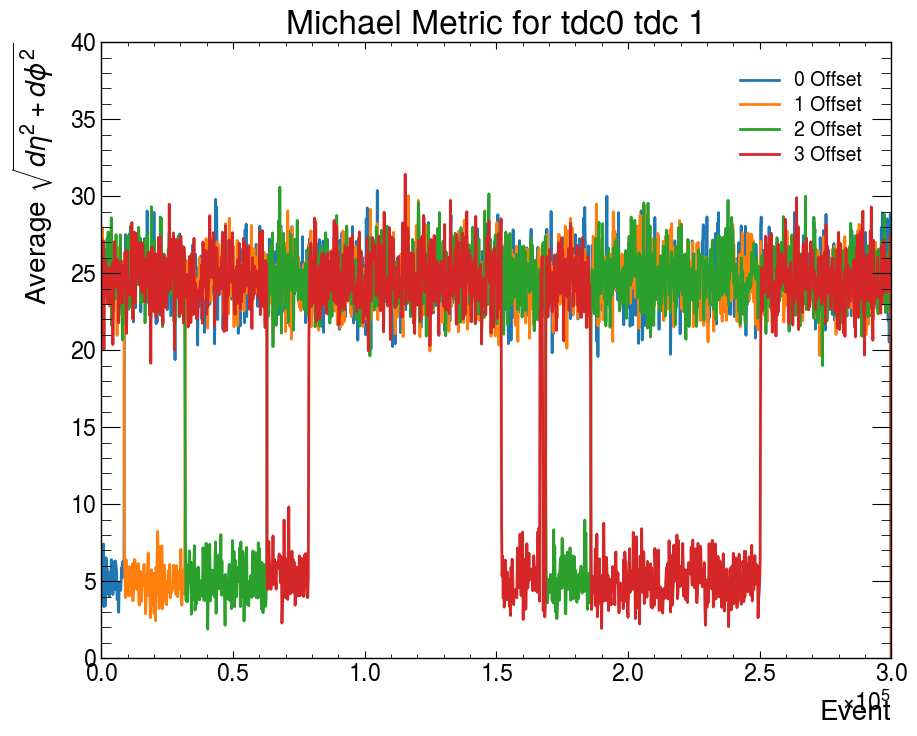

In [45]:
binsx = [x*200 for x in range(3000)]
noffs = 4
offsets = [[0 for xbin in binsx] for offset in range(noffs)]
offsetOne = [0 for xbin in binsx]
for testOff in range(noffs):
    xbin=0
    counts=0
    for idx, offset in enumerate(offsetTest[testOff]):
        if offset>-0.5:
            offsets[testOff][xbin]=offsets[testOff][xbin]+offset
            counts = counts+1
        if idx%200==0 and idx>0:
            if counts>0:
                offsets[testOff][xbin]=offsets[testOff][xbin]/counts
            xbin=xbin+1
            counts=0
    if counts>0:
        offsets[testOff][xbin]=offsets[testOff][xbin]/counts

fig, ax = plt.subplots(figsize=(10, 8))
for idx, offsethist in enumerate(offsets):
    ax.plot(binsx,offsethist,label=str(idx)+' Offset')

ax.set_xlim(0,300000)
ax.set_ylim(0,40)
ax.legend()
ax.set_title('Michael Metric for tdc0 tdc 1')
ax.set_ylabel('Average $\sqrt{d\eta^2+d\phi^2}$')
ax.set_xlabel('Event')
plt.show()

In [46]:
importlib.reload(rawFileReader)
fReader = rawFileReader.fileReader(file_path)
processedEvents = 0
events = []
lastWasBad = False
while processedEvents<300000:
    if not fReader.readBlock():
        print("Bad Block Read")
        break
    if(fReader.hasEvents()):
        for event in fReader.getEvents():
            events.append(event)
            processedEvents = processedEvents+1
            if processedEvents%200==0 and processedEvents>0:
                aligned = doRealign(fReader,events[-200:])
                if lastWasBad and not aligned:
                    print("Two bad aligns in a row, processedEvents is",processedEvents)
                elif not aligned:
                    lastWasBad = True
                else:
                    lastWasBad = False

Found a new alignment, offsetting by 1 idx is 9000
Found a new alignment, offsetting by 1 idx is 32200
Found a new alignment, offsetting by 1 idx is 63200
Found a new alignment, offsetting by 1 idx is 79000
Found a new alignment, offsetting by 1 idx is 122200
Found a new alignment, offsetting by -1 idx is 128000
Found a new alignment, offsetting by -1 idx is 152200
Found a new alignment, offsetting by 1 idx is 167000
Found a new alignment, offsetting by -1 idx is 168000
Found a new alignment, offsetting by -1 idx is 169200
Found a new alignment, offsetting by 1 idx is 186200
Found a new alignment, offsetting by 1 idx is 250800
Found a new alignment, offsetting by 1 idx is 257200
Found a new alignment, offsetting by 1 idx is 266000
Found a new alignment, offsetting by 1 idx is 283400


In [47]:
offsetTest = []
for offSet in range(4):
    offsetTest.append([])
    print(offSet)
    for idx, event in enumerate(events):
        etaHits = [[] for rpc in range(6)]
        phiHits = [[] for rpc in range(6)]
        if (idx+offSet)<len(events):
            if offSet>25:
                oneIdx = idx+offSet-25
                twoIdx = idx
            else:
                oneIdx = idx
                twoIdx = idx+offSet
            for word in events[oneIdx].tdcEvents[1].words:
                rpc, thisHit = tdcChanToRPCHit(word,1)
                if thisHit.eta:
                    etaHits[rpc].append(thisHit)
                else:
                    phiHits[rpc].append(thisHit)
            for word in events[twoIdx].tdcEvents[0].words:
                rpc, thisHit = tdcChanToRPCHit(word,0)
                if thisHit.eta:
                    etaHits[rpc].append(thisHit)
                else:
                    phiHits[rpc].append(thisHit)        
            etOff = testAlign(etaHits[1],etaHits[2])
            phOff = testAlign(phiHits[0],phiHits[1])
            Metric = etOff*etOff+phOff*phOff
            # print(Metric)
            if etOff>=0 and phOff>=0:
                offsetTest[-1].append(math.sqrt(Metric))
            else:
                offsetTest[-1].append(-1)
            #if etOff>0:
            #    offsetTest[-1].append(etOff)   


0
1
2
3


<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Peter\AppData\Local\Temp\ipykernel_31076\1382958311.py:28: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('Average $\sqrt{d\eta^2+d\phi^2}$')


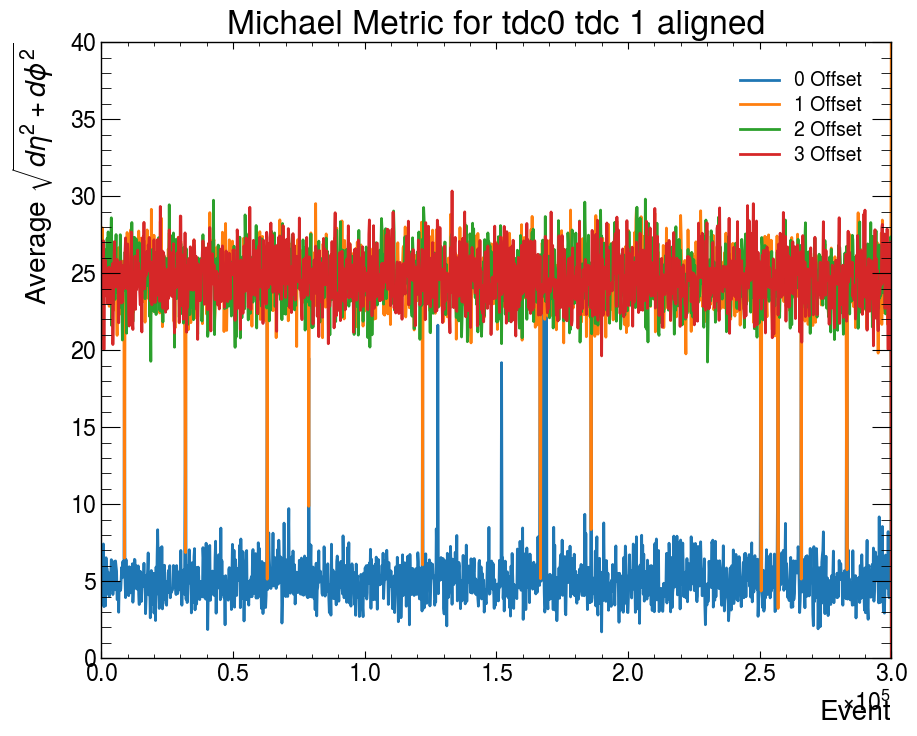

In [48]:
binsx = [x*200 for x in range(3000)]
noffs = 4
offsets = [[0 for xbin in binsx] for offset in range(noffs)]
offsetOne = [0 for xbin in binsx]
for testOff in range(noffs):
    xbin=0
    counts=0
    for idx, offset in enumerate(offsetTest[testOff]):
        if offset>-0.5:
            offsets[testOff][xbin]=offsets[testOff][xbin]+offset
            counts = counts+1
        if idx%200==0 and idx>0:
            if counts>0:
                offsets[testOff][xbin]=offsets[testOff][xbin]/counts
            xbin=xbin+1
            counts=0
    if counts>0:
        offsets[testOff][xbin]=offsets[testOff][xbin]/counts

fig, ax = plt.subplots(figsize=(10, 8))
for idx, offsethist in enumerate(offsets):
    ax.plot(binsx,offsethist,label=str(idx)+' Offset')

ax.set_xlim(0,300000)
ax.set_ylim(0,40)
ax.legend()
ax.set_title('Michael Metric for tdc0 tdc 1 aligned')
ax.set_ylabel('Average $\sqrt{d\eta^2+d\phi^2}$')
ax.set_xlabel('Event')
plt.show()

Now we can generalise this method into other TDCs

In [69]:
importlib.reload(rawFileReader)
fReader = rawFileReader.fileReader(file_path)
processedEvents = 0
events = []
lastWasBad = False
while processedEvents<300000:
    if not fReader.readBlock():
        print("Bad Block Read")
        break
    if(fReader.hasEvents()):
        for event in fReader.getEvents():
            events.append(event)
            processedEvents = processedEvents+1
            if processedEvents%200==0 and processedEvents>0:
                # aligned = doRealign(fReader,events[-200:])
                if lastWasBad and not aligned:
                    print("Two bad aligns in a row, processedEvents is",processedEvents)
                elif not aligned:
                    lastWasBad = True
                else:
                    lastWasBad = False

In [70]:
offsetTest = []
for offSet in range(4):
    offsetTest.append([])
    print(offSet)
    for idx, event in enumerate(events):
        etaHits = [[] for rpc in range(6)]
        phiHits = [[] for rpc in range(6)]
        if (idx+offSet)<len(events):
            if offSet>25:
                oneIdx = idx+offSet-25
                twoIdx = idx
            else:
                oneIdx = idx
                twoIdx = idx+offSet
            for word in events[oneIdx].tdcEvents[2].words:
                rpc, thisHit = tdcChanToRPCHit(word,2)
                if thisHit.eta:
                    etaHits[rpc].append(thisHit)
                else:
                    phiHits[rpc].append(thisHit)
            for word in events[twoIdx].tdcEvents[1].words:
                rpc, thisHit = tdcChanToRPCHit(word,1)
                if thisHit.eta:
                    etaHits[rpc].append(thisHit)
                else:
                    phiHits[rpc].append(thisHit)        
            etOff = testAlign(etaHits[2],etaHits[3])
            phOff = testAlign(phiHits[2],phiHits[3])
            Metric = etOff*etOff+phOff*phOff
            # print(Metric)
            if etOff>=0 and phOff>=0:
                offsetTest[-1].append(math.sqrt(Metric))
            else:
                offsetTest[-1].append(-1)
            #if etOff>0:
            #    offsetTest[-1].append(etOff)   

0
1
2
3


<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Peter\AppData\Local\Temp\ipykernel_31076\4083300612.py:28: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('Average $\sqrt{d\eta^2+d\phi^2}$')


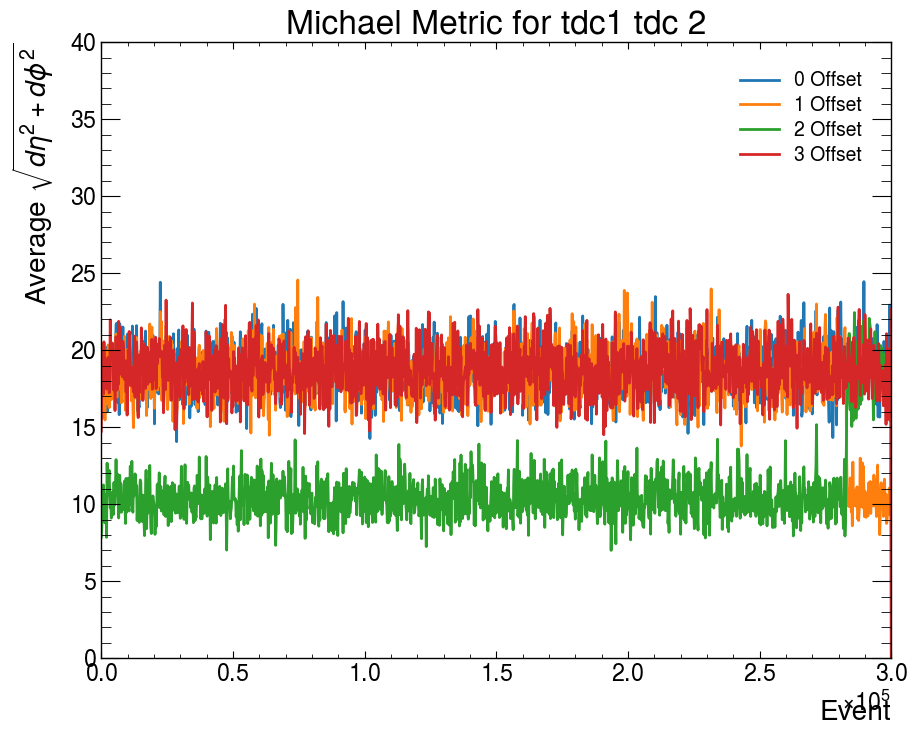

In [71]:
binsx = [x*200 for x in range(3000)]
noffs = 4
offsets = [[0 for xbin in binsx] for offset in range(noffs)]
offsetOne = [0 for xbin in binsx]
for testOff in range(noffs):
    xbin=0
    counts=0
    for idx, offset in enumerate(offsetTest[testOff]):
        if offset>-0.5:
            offsets[testOff][xbin]=offsets[testOff][xbin]+offset
            counts = counts+1
        if idx%200==0 and idx>0:
            if counts>0:
                offsets[testOff][xbin]=offsets[testOff][xbin]/counts
            xbin=xbin+1
            counts=0
    if counts>0:
        offsets[testOff][xbin]=offsets[testOff][xbin]/counts

fig, ax = plt.subplots(figsize=(10, 8))
for idx, offsethist in enumerate(offsets):
    ax.plot(binsx,offsethist,label=str(idx)+' Offset')

ax.set_xlim(0,300000)
ax.set_ylim(0,40)
ax.legend()
ax.set_title('Michael Metric for tdc1 tdc 2')
ax.set_ylabel('Average $\sqrt{d\eta^2+d\phi^2}$')
ax.set_xlabel('Event')
plt.show()

In [66]:
importlib.reload(rawFileReader)
fReader = rawFileReader.fileReader(file_path)
processedEvents = 0
events = []
lastWasBad = False
while processedEvents<300000:
    if not fReader.readBlock():
        print("Bad Block Read")
        break
    if(fReader.hasEvents()):
        for event in fReader.getEvents():
            events.append(event)
            processedEvents = processedEvents+1
            if processedEvents%200==0 and processedEvents>0:
                aligned = doRealign(fReader,events[-200:], 2, 3, 2, 3, 1, 2)
                if lastWasBad and not aligned:
                    print("Two bad aligns in a row, processedEvents is",processedEvents)
                elif not aligned:
                    lastWasBad = True
                else:
                    lastWasBad = False

Found a new alignment, offsetting by -2 idx is 200
Two bad aligns in a row, processedEvents is 1000
Two bad aligns in a row, processedEvents is 1200
Two bad aligns in a row, processedEvents is 1400
Two bad aligns in a row, processedEvents is 2600
Two bad aligns in a row, processedEvents is 2800
Two bad aligns in a row, processedEvents is 3000
Two bad aligns in a row, processedEvents is 3200
Two bad aligns in a row, processedEvents is 3400
Two bad aligns in a row, processedEvents is 4400
Two bad aligns in a row, processedEvents is 5600
Two bad aligns in a row, processedEvents is 5800
Two bad aligns in a row, processedEvents is 6000
Two bad aligns in a row, processedEvents is 6200
Two bad aligns in a row, processedEvents is 6400
Two bad aligns in a row, processedEvents is 6600
Two bad aligns in a row, processedEvents is 7200
Two bad aligns in a row, processedEvents is 7400
Two bad aligns in a row, processedEvents is 7600
Two bad aligns in a row, processedEvents is 9000
Two bad aligns in 

In [67]:
offsetTest = []
for offSet in range(4):
    offsetTest.append([])
    print(offSet)
    for idx, event in enumerate(events):
        etaHits = [[] for rpc in range(6)]
        phiHits = [[] for rpc in range(6)]
        if (idx+offSet)<len(events):
            if offSet>25:
                oneIdx = idx+offSet-25
                twoIdx = idx
            else:
                oneIdx = idx
                twoIdx = idx+offSet
            for word in events[oneIdx].tdcEvents[2].words:
                rpc, thisHit = tdcChanToRPCHit(word,2)
                if thisHit.eta:
                    etaHits[rpc].append(thisHit)
                else:
                    phiHits[rpc].append(thisHit)
            for word in events[twoIdx].tdcEvents[1].words:
                rpc, thisHit = tdcChanToRPCHit(word,1)
                if thisHit.eta:
                    etaHits[rpc].append(thisHit)
                else:
                    phiHits[rpc].append(thisHit)        
            etOff = testAlign(etaHits[2],etaHits[3])
            phOff = testAlign(phiHits[2],phiHits[3])
            Metric = etOff*etOff+phOff*phOff
            # print(Metric)
            if etOff>=0 and phOff>=0:
                offsetTest[-1].append(math.sqrt(Metric))
            else:
                offsetTest[-1].append(-1)
            #if etOff>0:
            #    offsetTest[-1].append(etOff)  

0
1
2
3


<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Peter\AppData\Local\Temp\ipykernel_31076\4083300612.py:28: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('Average $\sqrt{d\eta^2+d\phi^2}$')


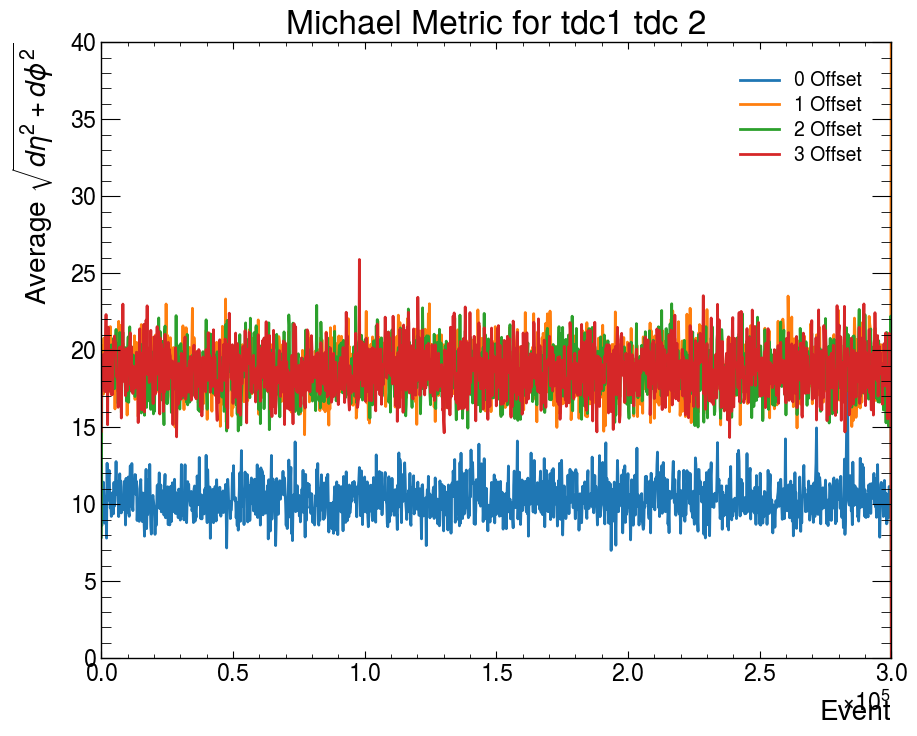

In [68]:
binsx = [x*200 for x in range(3000)]
noffs = 4
offsets = [[0 for xbin in binsx] for offset in range(noffs)]
offsetOne = [0 for xbin in binsx]
for testOff in range(noffs):
    xbin=0
    counts=0
    for idx, offset in enumerate(offsetTest[testOff]):
        if offset>-0.5:
            offsets[testOff][xbin]=offsets[testOff][xbin]+offset
            counts = counts+1
        if idx%200==0 and idx>0:
            if counts>0:
                offsets[testOff][xbin]=offsets[testOff][xbin]/counts
            xbin=xbin+1
            counts=0
    if counts>0:
        offsets[testOff][xbin]=offsets[testOff][xbin]/counts

fig, ax = plt.subplots(figsize=(10, 8))
for idx, offsethist in enumerate(offsets):
    ax.plot(binsx,offsethist,label=str(idx)+' Offset')

ax.set_xlim(0,300000)
ax.set_ylim(0,40)
ax.legend()
ax.set_title('Michael Metric for tdc1 tdc 2')
ax.set_ylabel('Average $\sqrt{d\eta^2+d\phi^2}$')
ax.set_xlabel('Event')
plt.show()